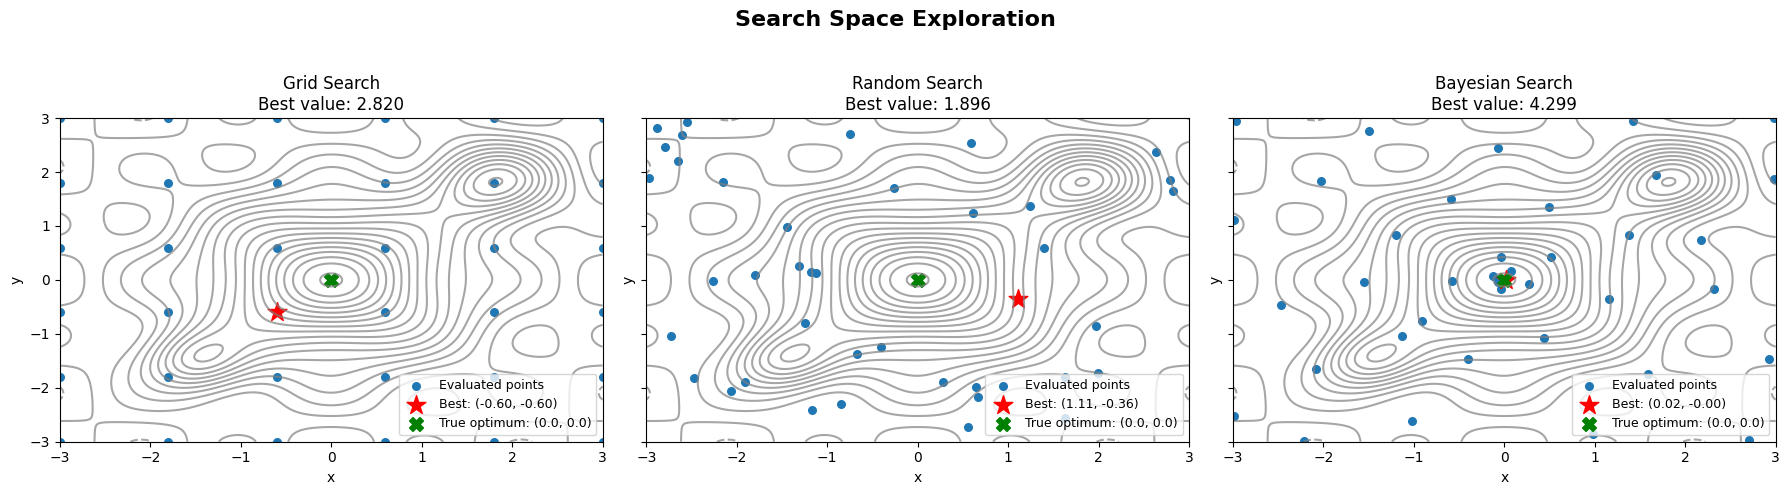

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.stats import norm

# 1) Define the objective function
def objective_function(x, y):
    term1 = 4 * np.exp(-0.5 * (x**2 + y**2))
    term2 = 2.5 * np.exp(-2 * ((x - 1.8)**2 + (y - 1.8)**2))
    term3 = 0.3 * np.cos(3 * x) * np.cos(3 * y)
    term4 = 1.8 * np.exp(-3 * ((x + 1.5)**2 + (y + 1.5)**2))
    return term1 + term2 + term3 + term4

# 2) Settings
GRID_RES = 6                 # Resolution for Grid Search (6×6)
N_ITER   = 40                # Number of evaluations for Random/Bayesian
SEED     = 42
TRUE_OPT = (0.0, 0.0)        # True global optimum
np.random.seed(SEED)

# 3) Collect samples for each method
records = {'Grid': [], 'Random': [], 'Bayesian': []}

# 3.1 Grid Search samples
x_vals = np.linspace(-3, 3, GRID_RES)
y_vals = np.linspace(-3, 3, GRID_RES)
for x in x_vals:
    for y in y_vals:
        val = objective_function(x, y)
        records['Grid'].append(((x, y), val))

# 3.2 Random Search samples
for _ in range(N_ITER):
    x = np.random.uniform(-3, 3)
    y = np.random.uniform(-3, 3)
    val = objective_function(x, y)
    records['Random'].append(((x, y), val))

# 3.3 Bayesian Optimization (Gaussian Process)
# 3.3.1 Initial random samples
n_init = 5
X_sample = np.random.uniform(-3, 3, (n_init, 2))
Y_sample = [objective_function(x, y) for x, y in X_sample]
for (x, y), v in zip(X_sample, Y_sample):
    records['Bayesian'].append(((x, y), v))

# 3.3.2 GP model and EI acquisition
gpr = GaussianProcessRegressor(kernel=Matern(nu=2.5), alpha=1e-6)
bounds = np.array([[-3, 3], [-3, 3]])

def propose_next_ei(gpr, X, Y, bounds, n_cand=2000, xi=0.01):
    # Generate candidate points
    X_cand = np.random.uniform(bounds[:,0], bounds[:,1], size=(n_cand, 2))
    mu, sigma = gpr.predict(X_cand, return_std=True)
    mu_opt = gpr.predict(X).max()
    with np.errstate(divide='ignore'):
        imp = mu - mu_opt - xi
        Z   = imp / sigma
        ei  = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0] = 0.0
    next_idx = np.argmax(ei)
    return X_cand[next_idx].reshape(1, 2)

# 3.3.3 Sequential optimization
for _ in range(N_ITER - n_init):
    gpr.fit(X_sample, np.array(Y_sample))
    x_next = propose_next_ei(gpr, X_sample, Y_sample, bounds)[0]
    y_next = objective_function(*x_next)
    X_sample = np.vstack([X_sample, x_next])
    Y_sample.append(y_next)
    records['Bayesian'].append(((x_next[0], x_next[1]), y_next))

# 4) Prepare contour grid
Xc = np.linspace(-3, 3, 200)
Yc = np.linspace(-3, 3, 200)
XX, YY = np.meshgrid(Xc, Yc)
ZZ = objective_function(XX, YY)

# 5) Plot side-by-side panels
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, method in zip(axes, ['Grid', 'Random', 'Bayesian']):
    pts, vals = zip(*records[method])
    xs, ys    = zip(*pts)
    # 5.1 Contour lines
    ax.contour(XX, YY, ZZ, levels=20, colors='gray', alpha=0.7)
    # 5.2 Evaluated points
    ax.scatter(xs, ys, c='tab:blue', s=30, label='Evaluated points')
    # 5.3 Best found
    best_idx = np.argmax(vals)
    bx, by    = xs[best_idx], ys[best_idx]
    bv        = vals[best_idx]
    ax.scatter(bx, by, marker='*', color='red', s=200,
               label=f'Best: ({bx:.2f}, {by:.2f})')
    # 5.4 True optimum
    ax.scatter(*TRUE_OPT, marker='X', color='green', s=100,
               label=f'True optimum: ({TRUE_OPT[0]:.1f}, {TRUE_OPT[1]:.1f})')
    # 5.5 Titles and legend
    ax.set_title(f'{method} Search\nBest value: {bv:.3f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='lower right', fontsize=9)

fig.suptitle('Search Space Exploration', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("./result/0_search_comp/search_space_exploration.png")
plt.show()



In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.stats import norm

# 1) Define the objective function
def objective_function(x, y):
    return (
        4 * np.exp(-0.5 * (x**2 + y**2)) +
        2.5 * np.exp(-2 * ((x - 1.8)**2 + (y - 1.8)**2)) +
        0.3 * np.cos(3*x) * np.cos(3*y) +
        1.8 * np.exp(-3 * ((x + 1.5)**2 + (y + 1.5)**2))
    )

# 2) Settings
GRID_RES = 6        # Grid resolution
N_ITER   = 40       # Number of random/Bayesian steps
SEED     = 42
TRUE_OPT = (0.0, 0.0)
np.random.seed(SEED)

# 3) Generate sampling records for each method
records = {'Grid': [], 'Random': [], 'Bayesian': []}

# 3.1 Grid Search
xg = np.linspace(-3, 3, GRID_RES)
yg = np.linspace(-3, 3, GRID_RES)
for x in xg:
    for y in yg:
        records['Grid'].append(((x, y), objective_function(x, y)))

# 3.2 Random Search
for _ in range(N_ITER):
    x, y = np.random.uniform(-3, 3), np.random.uniform(-3, 3)
    records['Random'].append(((x, y), objective_function(x, y)))

# 3.3 Bayesian GP Search
#   3.3.1 Initial random samples
n_init = 5
X_samp = np.random.uniform(-3, 3, (n_init, 2))
Y_samp = [objective_function(x, y) for x, y in X_samp]
for (x, y), v in zip(X_samp, Y_samp):
    records['Bayesian'].append(((x, y), v))

#   3.3.2 GP model + Expected Improvement
gpr    = GaussianProcessRegressor(kernel=Matern(nu=2.5), alpha=1e-6)
bounds = np.array([[-3, 3], [-3, 3]])
def propose_next_ei(gpr, X, Y, bounds, n_cand=2000, xi=0.01):
    Xc = np.random.uniform(bounds[:,0], bounds[:,1], (n_cand, 2))
    mu, sigma = gpr.predict(Xc, return_std=True)
    mu_opt = gpr.predict(X).max()
    with np.errstate(divide='ignore'):
        imp = mu - mu_opt - xi
        Z   = imp / sigma
        ei  = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0] = 0.0
    idx = np.argmax(ei)
    return Xc[idx].reshape(1, 2)

#   3.3.3 Sequential Bayesian optimization
for _ in range(N_ITER - n_init):
    gpr.fit(X_samp, np.array(Y_samp))
    x_next = propose_next_ei(gpr, X_samp, Y_samp, bounds)[0]
    y_next = objective_function(*x_next)
    X_samp = np.vstack([X_samp, x_next])
    Y_samp.append(y_next)
    records['Bayesian'].append(((x_next[0], x_next[1]), y_next))

# 4) Prepare contour background
Xc = np.linspace(-3, 3, 200)
Yc = np.linspace(-3, 3, 200)
XX, YY = np.meshgrid(Xc, Yc)
ZZ = objective_function(XX, YY)

# 5) Set up figure & artists
methods   = ['Grid', 'Random', 'Bayesian']
max_steps = max(len(records[m]) for m in methods)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# draw contour once
for ax in axes:
    ax.contour(XX, YY, ZZ, levels=20, colors='gray', alpha=0.7)

# prepare scatter & best‐marker objects
scatter_pts  = {}
scatter_best = {}
for ax, method in zip(axes, methods):
    scatter_pts[method]  = ax.scatter([], [], c='tab:blue', s=30)
    scatter_best[method] = ax.scatter([], [], marker='*', c='red', s=150)
    ax.scatter(*TRUE_OPT, marker='X', c='green', s=100)
    ax.set_title(f'{method} Search\nStep 0')
    ax.set_xlabel('x'); ax.set_ylabel('y')

# 6) Animation update
def update(frame):
    for method, ax in zip(methods, axes):
        pts_vals = records[method][:min(frame+1, len(records[method]))]
        pts, vals = zip(*pts_vals)
        xs, ys    = zip(*pts)
        scatter_pts[method].set_offsets(np.c_[xs, ys])
        best_idx = int(np.argmax(vals))
        bx, by   = xs[best_idx], ys[best_idx]
        scatter_best[method].set_offsets([[bx, by]])
        ax.set_title(f'{method} Search\nStep {min(frame, len(pts_vals)-1)}')
    return list(scatter_pts.values()) + list(scatter_best.values())

# 7) Save animation as GIF in current directory
output_path = 'search_progress.gif'
anim = FuncAnimation(fig, update, frames=max_steps, interval=500, blit=True)
anim.save(f'./result/0_search_comp/{output_path}', writer=PillowWriter(fps=2))
plt.close(fig)

print(f'Animation saved to ./{output_path}')


Animation saved to ./search_progress.gif


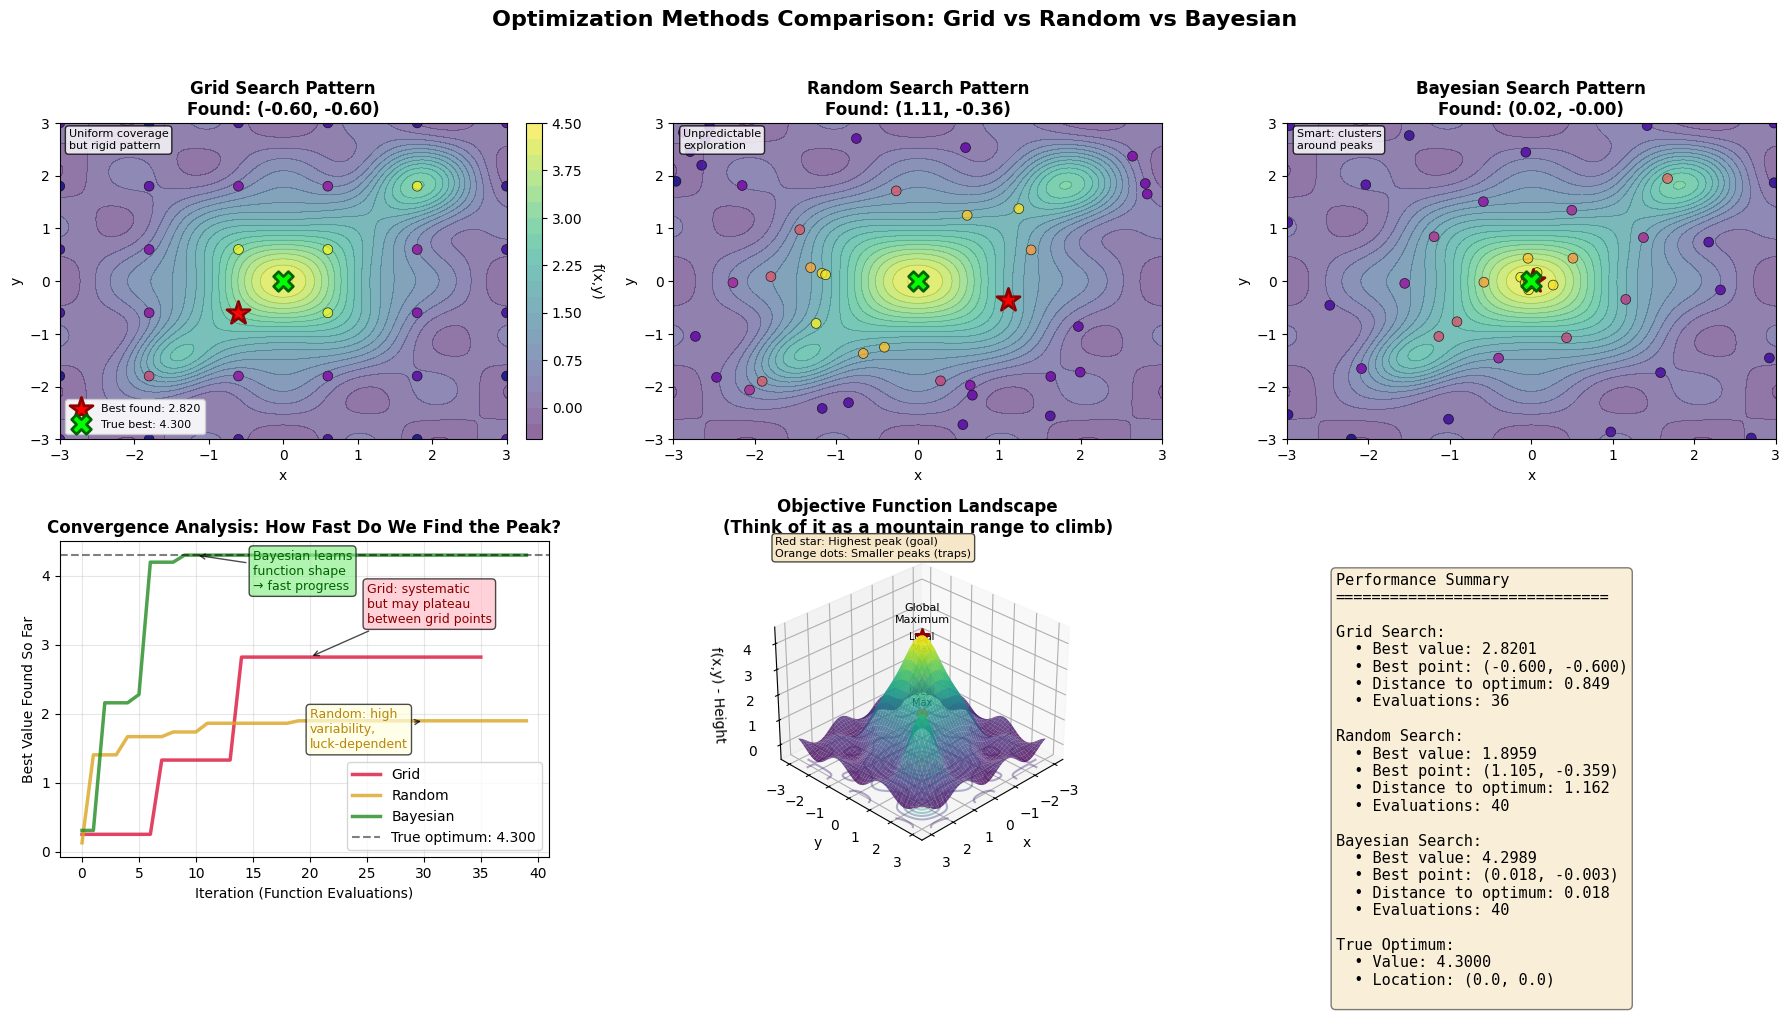


Creating animation...
Animation saved to ./optimization_comparison.gif

KEY INSIGHTS FROM THIS VISUALIZATION:

1. GRID SEARCH:
   - Evaluates: 36 points (6×6 grid)
   - Pattern: Systematic, uniform coverage
   - Risk: Might miss peaks between grid points
   - Best for: Low-dimensional problems with computational budget

2. RANDOM SEARCH:
   - Evaluates: 40 random points
   - Pattern: Chaotic, unpredictable
   - Risk: Might waste evaluations in poor regions
   - Best for: High-dimensional problems where grid becomes impractical

3. BAYESIAN OPTIMIZATION:
   - Evaluates: 40 intelligently chosen points
   - Pattern: Clusters around promising regions
   - Advantage: Learns from past evaluations
   - Best for: Expensive evaluations (e.g., training neural networks)

4. THE 3D SURFACE shows why this is challenging:
   - Multiple peaks create 'local optima traps'
   - The global maximum might be surrounded by valleys
   - Small ripples add noise to the optimization

5. REAL-WORLD APPLICATIONS

In [10]:
"""
Optimization Methods Comparison: Grid vs Random vs Bayesian

This visualization demonstrates three different approaches to finding the maximum
of a complex function (like finding the highest peak in a mountain range):

1. GRID SEARCH: 
   - Like checking elevation at regular intervals on a map
   - Systematic but might miss peaks between measurement points
   
2. RANDOM SEARCH:
   - Like dropping pins randomly on a map
   - Can find unexpected peaks but no guarantee of success
   
3. BAYESIAN OPTIMIZATION:
   - Like having a smart assistant that learns the terrain
   - Uses past measurements to predict where high peaks might be
   - Balances exploring new areas vs. exploiting known good areas

The objective function simulates a real optimization challenge with:
- Multiple peaks (global and local maxima)
- Smooth regions and rough patches
- The kind of complexity found in real-world problems like:
  * Hyperparameter tuning in machine learning
  * Engineering design optimization
  * Scientific experiment planning
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.stats import norm

# 1) Define the objective function
def objective_function(x, y):
    """
    Multi-modal objective function with:
    - One global maximum at (0,0) 
    - Two local maxima at (1.8,1.8) and (-1.5,-1.5)
    - Small ripples throughout from cosine terms
    
    This simulates a challenging optimization landscape where:
    - Grid Search might miss peaks between grid points
    - Random Search might get stuck in local maxima
    - Bayesian Optimization can learn the function shape to find global maximum
    """
    # Main peak at origin - this is our global maximum
    term1 = 4 * np.exp(-0.5 * (x**2 + y**2))
    
    # Secondary peak at (1.8, 1.8) - a local maximum trap
    term2 = 2.5 * np.exp(-2 * ((x - 1.8)**2 + (y - 1.8)**2))
    
    # Ripple effect - creates small bumps making optimization harder
    term3 = 0.3 * np.cos(3 * x) * np.cos(3 * y)
    
    # Third peak at (-1.5, -1.5) - another local maximum
    term4 = 1.8 * np.exp(-3 * ((x + 1.5)**2 + (y + 1.5)**2))
    
    return term1 + term2 + term3 + term4

# 2) Settings
GRID_RES = 6        # Grid resolution
N_ITER   = 40       # Number of random/Bayesian steps
SEED     = 42
TRUE_OPT = (0.0, 0.0)
np.random.seed(SEED)

# 3) Generate sampling records for each method
records = {'Grid': [], 'Random': [], 'Bayesian': []}
convergence = {'Grid': [], 'Random': [], 'Bayesian': []}

# 3.1 Grid Search
# Systematic but rigid: evaluates function at fixed grid points
# Pro: Covers space uniformly, guaranteed to check all grid points
# Con: Might miss the peak if it falls between grid points
xg = np.linspace(-3, 3, GRID_RES)
yg = np.linspace(-3, 3, GRID_RES)
best_val_grid = -np.inf
for x in xg:
    for y in yg:
        val = objective_function(x, y)
        records['Grid'].append(((x, y), val))
        best_val_grid = max(best_val_grid, val)
        convergence['Grid'].append(best_val_grid)

# 3.2 Random Search
# Stochastic exploration: randomly samples points
# Pro: Can potentially find peaks anywhere, not limited to grid
# Con: No guarantee of finding optimum, might waste time in poor regions
best_val_random = -np.inf
for _ in range(N_ITER):
    x, y = np.random.uniform(-3, 3), np.random.uniform(-3, 3)
    val = objective_function(x, y)
    records['Random'].append(((x, y), val))
    best_val_random = max(best_val_random, val)
    convergence['Random'].append(best_val_random)

# 3.3 Bayesian GP Search
# Intelligent search: builds a probabilistic model of the function
# Pro: Learns from previous evaluations, focuses on promising areas
# Con: More complex, requires tuning of acquisition function
#   3.3.1 Initial random samples
n_init = 5
X_samp = np.random.uniform(-3, 3, (n_init, 2))
Y_samp = [objective_function(x, y) for x, y in X_samp]
best_val_bayes = -np.inf
for (x, y), v in zip(X_samp, Y_samp):
    records['Bayesian'].append(((x, y), v))
    best_val_bayes = max(best_val_bayes, v)
    convergence['Bayesian'].append(best_val_bayes)

#   3.3.2 GP model + Expected Improvement
gpr = GaussianProcessRegressor(kernel=Matern(nu=2.5), alpha=1e-6)
bounds = np.array([[-3, 3], [-3, 3]])

def propose_next_ei(gpr, X, Y, bounds, n_cand=2000, xi=0.01):
    """
    Expected Improvement (EI) acquisition function
    
    This function answers: "Where should we look next to likely find a better value?"
    It balances:
    - Exploitation: Areas where the model predicts high values (mu)
    - Exploration: Areas with high uncertainty (sigma)
    
    The EI formula considers both the predicted improvement AND 
    the probability of that improvement happening.
    """
    # Generate candidate points to evaluate
    Xc = np.random.uniform(bounds[:,0], bounds[:,1], (n_cand, 2))
    
    # Get GP predictions: mean (expected value) and uncertainty
    mu, sigma = gpr.predict(Xc, return_std=True)
    
    # Current best observed value
    mu_opt = gpr.predict(X).max()
    
    # Calculate expected improvement
    with np.errstate(divide='ignore'):
        # How much better could this point be?
        imp = mu - mu_opt - xi  # xi adds small exploration bonus
        
        # Normalize by uncertainty
        Z = imp / sigma
        
        # EI = (expected improvement) × (probability of improvement)
        #     + (uncertainty) × (probability density)
        # This elegantly balances exploitation and exploration!
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0] = 0.0  # No uncertainty = no exploration value
    
    # Return the point with highest expected improvement
    idx = np.argmax(ei)
    return Xc[idx].reshape(1, 2)

#   3.3.3 Sequential Bayesian optimization
for _ in range(N_ITER - n_init):
    gpr.fit(X_samp, np.array(Y_samp))
    x_next = propose_next_ei(gpr, X_samp, Y_samp, bounds)[0]
    y_next = objective_function(*x_next)
    X_samp = np.vstack([X_samp, x_next])
    Y_samp.append(y_next)
    records['Bayesian'].append(((x_next[0], x_next[1]), y_next))
    best_val_bayes = max(best_val_bayes, y_next)
    convergence['Bayesian'].append(best_val_bayes)

# 4) Prepare contour background
Xc = np.linspace(-3, 3, 200)
Yc = np.linspace(-3, 3, 200)
XX, YY = np.meshgrid(Xc, Yc)
ZZ = objective_function(XX, YY)

# 5) Create comprehensive figure with multiple subplots
fig = plt.figure(figsize=(18, 10))

# 5.1) Top row: Search space exploration for each method
methods = ['Grid', 'Random', 'Bayesian']
for i, method in enumerate(methods):
    ax = plt.subplot(2, 3, i+1)
    
    # Contour plot showing the "terrain"
    contour = ax.contourf(XX, YY, ZZ, levels=20, cmap='viridis', alpha=0.6)
    ax.contour(XX, YY, ZZ, levels=20, colors='gray', alpha=0.3, linewidths=0.5)
    
    # Plot all evaluated points
    pts, vals = zip(*records[method])
    xs, ys = zip(*pts)
    
    # Color points by their value - helps visualize search efficiency
    scatter = ax.scatter(xs, ys, c=vals, cmap='plasma', s=50, 
                        edgecolors='black', linewidth=0.5, alpha=0.8)
    
    # Mark best found point with a star
    best_idx = np.argmax(vals)
    bx, by = xs[best_idx], ys[best_idx]
    bv = vals[best_idx]
    ax.scatter(bx, by, marker='*', color='red', s=300, 
               edgecolors='darkred', linewidth=2,
               label=f'Best found: {bv:.3f}')
    
    # Mark true optimum with an X
    ax.scatter(*TRUE_OPT, marker='X', color='lime', s=200, 
               edgecolors='darkgreen', linewidth=2,
               label=f'True best: {objective_function(*TRUE_OPT):.3f}')
    
    # Add method-specific insights
    if method == 'Grid':
        ax.text(0.02, 0.98, 'Uniform coverage\nbut rigid pattern', 
                transform=ax.transAxes, fontsize=8, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    elif method == 'Random':
        ax.text(0.02, 0.98, 'Unpredictable\nexploration', 
                transform=ax.transAxes, fontsize=8, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    elif method == 'Bayesian':
        ax.text(0.02, 0.98, 'Smart: clusters\naround peaks', 
                transform=ax.transAxes, fontsize=8, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Labels and title
    ax.set_title(f'{method} Search Pattern\nFound: ({bx:.2f}, {by:.2f})', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    
    # Add legend only for first subplot
    if i == 0:
        ax.legend(loc='lower left', fontsize=8, framealpha=0.9)
    
    # Add colorbar for the first subplot
    if i == 0:
        cbar = plt.colorbar(contour, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('f(x,y)', rotation=270, labelpad=15)

# 5.2) Bottom left: Convergence comparison
ax_conv = plt.subplot(2, 3, 4)
colors = {'Grid': 'crimson', 'Random': 'goldenrod', 'Bayesian': 'forestgreen'}

# Plot convergence curves with thicker lines for clarity
for method in methods:
    ax_conv.plot(convergence[method], label=method, color=colors[method], 
                 linewidth=2.5, alpha=0.8)

# Add horizontal line for true optimum
true_opt_value = objective_function(*TRUE_OPT)
ax_conv.axhline(y=true_opt_value, color='black', linestyle='--', alpha=0.5, 
                label=f'True optimum: {true_opt_value:.3f}')

ax_conv.set_title('Convergence Analysis: How Fast Do We Find the Peak?', 
                  fontsize=12, fontweight='bold')
ax_conv.set_xlabel('Iteration (Function Evaluations)')
ax_conv.set_ylabel('Best Value Found So Far')
ax_conv.legend(loc='lower right')
ax_conv.grid(True, alpha=0.3)

# Add annotations to explain convergence patterns
# Bayesian fast start
if len(convergence['Bayesian']) > 10:
    ax_conv.annotate('Bayesian learns\nfunction shape\n→ fast progress', 
                     xy=(10, convergence['Bayesian'][10]), 
                     xytext=(15, convergence['Bayesian'][10]-0.5),
                     arrowprops=dict(facecolor='green', arrowstyle='->', alpha=0.7),
                     fontsize=9, color='darkgreen',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

# Grid search plateau
if len(convergence['Grid']) > 20:
    ax_conv.annotate('Grid: systematic\nbut may plateau\nbetween grid points', 
                     xy=(20, convergence['Grid'][20]), 
                     xytext=(25, convergence['Grid'][20]+0.5),
                     arrowprops=dict(facecolor='crimson', arrowstyle='->', alpha=0.7),
                     fontsize=9, color='darkred',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='pink', alpha=0.7))

# Random search variability
if len(convergence['Random']) > 30:
    ax_conv.annotate('Random: high\nvariability,\nluck-dependent', 
                     xy=(30, convergence['Random'][30]), 
                     xytext=(20, 1.5),
                     arrowprops=dict(facecolor='goldenrod', arrowstyle='->', alpha=0.7),
                     fontsize=9, color='darkgoldenrod',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.7))

# 5.3) Bottom middle: 3D surface plot
ax_3d = plt.subplot(2, 3, 5, projection='3d')

# Create the 3D surface visualization
surf = ax_3d.plot_surface(XX, YY, ZZ, cmap='viridis', alpha=0.8, 
                          edgecolor='none', antialiased=True)

# Add contour lines at the bottom for better depth perception
contours = ax_3d.contour(XX, YY, ZZ, zdir='z', offset=ZZ.min()-0.5, 
                         cmap='viridis', alpha=0.4)

# Mark key points on the surface
# Global maximum (true optimum)
opt_val = objective_function(*TRUE_OPT)
ax_3d.scatter(*TRUE_OPT, opt_val, color='red', s=100, marker='*', 
              edgecolors='darkred', linewidth=2)

# Local maxima
local_max_1 = (1.8, 1.8, objective_function(1.8, 1.8))
local_max_2 = (-1.5, -1.5, objective_function(-1.5, -1.5))
ax_3d.scatter(*local_max_1, color='orange', s=50, marker='o')
ax_3d.scatter(*local_max_2, color='orange', s=50, marker='o')

# Add text annotations for peaks
ax_3d.text(0, 0, opt_val + 0.5, 'Global\nMaximum', fontsize=8, ha='center')
ax_3d.text(1.8, 1.8, local_max_1[2] + 0.3, 'Local\nMax', fontsize=7, ha='center')
ax_3d.text(-1.5, -1.5, local_max_2[2] + 0.3, 'Local\nMax', fontsize=7, ha='center')

ax_3d.set_title('Objective Function Landscape\n(Think of it as a mountain range to climb)', 
                fontsize=12, fontweight='bold')
ax_3d.set_xlabel('x')
ax_3d.set_ylabel('y')
ax_3d.set_zlabel('f(x,y) - Height')
ax_3d.view_init(elev=30, azim=45)

# Add a note about interpretation
ax_3d.text2D(0.05, 0.95, "Red star: Highest peak (goal)\nOrange dots: Smaller peaks (traps)", 
             transform=ax_3d.transAxes, fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# 5.4) Bottom right: Summary statistics
ax_stats = plt.subplot(2, 3, 6)
ax_stats.axis('off')

# Calculate statistics
stats_text = "Performance Summary\n" + "="*30 + "\n\n"
for method in methods:
    pts, vals = zip(*records[method])
    best_val = max(vals)
    best_idx = np.argmax(vals)
    best_x, best_y = pts[best_idx]
    dist_to_opt = np.sqrt((best_x - TRUE_OPT[0])**2 + (best_y - TRUE_OPT[1])**2)
    
    stats_text += f"{method} Search:\n"
    stats_text += f"  • Best value: {best_val:.4f}\n"
    stats_text += f"  • Best point: ({best_x:.3f}, {best_y:.3f})\n"
    stats_text += f"  • Distance to optimum: {dist_to_opt:.3f}\n"
    stats_text += f"  • Evaluations: {len(vals)}\n\n"

# Add true optimum info
true_opt_val = objective_function(*TRUE_OPT)
stats_text += f"True Optimum:\n"
stats_text += f"  • Value: {true_opt_val:.4f}\n"
stats_text += f"  • Location: {TRUE_OPT}\n"

ax_stats.text(0.1, 0.9, stats_text, transform=ax_stats.transAxes, 
              fontsize=11, verticalalignment='top', fontfamily='monospace',
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Overall title
fig.suptitle('Optimization Methods Comparison: Grid vs Random vs Bayesian', 
             fontsize=16, fontweight='bold')
plt.savefig("./result/0_search_comp/optimization_methods_comparison.png")
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

# 6) Create animation (optional - uncomment to generate)
print("\nCreating animation...")
max_steps = max(len(records[m]) for m in methods)
fig_anim, axes_anim = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# Draw contours
for ax in axes_anim:
    ax.contour(XX, YY, ZZ, levels=20, colors='gray', alpha=0.7)

# Prepare scatter objects
scatter_pts = {}
scatter_best = {}
for ax, method in zip(axes_anim, methods):
    scatter_pts[method] = ax.scatter([], [], c='tab:blue', s=30)
    scatter_best[method] = ax.scatter([], [], marker='*', c='red', s=150)
    ax.scatter(*TRUE_OPT, marker='X', c='green', s=100)
    ax.set_title(f'{method} Search\nStep 0')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

def update(frame):
    for method, ax in zip(methods, axes_anim):
        pts_vals = records[method][:min(frame+1, len(records[method]))]
        if pts_vals:
            pts, vals = zip(*pts_vals)
            xs, ys = zip(*pts)
            scatter_pts[method].set_offsets(np.c_[xs, ys])
            best_idx = int(np.argmax(vals))
            bx, by = xs[best_idx], ys[best_idx]
            scatter_best[method].set_offsets([[bx, by]])
            ax.set_title(f'{method} Search\nStep {min(frame, len(pts_vals)-1)}')
    return list(scatter_pts.values()) + list(scatter_best.values())

# Save animation
output_path = 'optimization_comparison.gif'
anim = FuncAnimation(fig_anim, update, frames=max_steps, interval=500, blit=True)
anim.save(f'./result/0_search_comp/{output_path}', writer=PillowWriter(fps=2))
plt.close(fig_anim)
print(f'Animation saved to ./{output_path}')

# Educational summary
print("\n" + "="*60)
print("KEY INSIGHTS FROM THIS VISUALIZATION:")
print("="*60)
print("\n1. GRID SEARCH:")
print("   - Evaluates: 36 points (6×6 grid)")
print("   - Pattern: Systematic, uniform coverage")
print("   - Risk: Might miss peaks between grid points")
print("   - Best for: Low-dimensional problems with computational budget")

print("\n2. RANDOM SEARCH:")
print("   - Evaluates: 40 random points")
print("   - Pattern: Chaotic, unpredictable")
print("   - Risk: Might waste evaluations in poor regions")
print("   - Best for: High-dimensional problems where grid becomes impractical")

print("\n3. BAYESIAN OPTIMIZATION:")
print("   - Evaluates: 40 intelligently chosen points")
print("   - Pattern: Clusters around promising regions")
print("   - Advantage: Learns from past evaluations")
print("   - Best for: Expensive evaluations (e.g., training neural networks)")

print("\n4. THE 3D SURFACE shows why this is challenging:")
print("   - Multiple peaks create 'local optima traps'")
print("   - The global maximum might be surrounded by valleys")
print("   - Small ripples add noise to the optimization")

print("\n5. REAL-WORLD APPLICATIONS:")
print("   - Machine Learning: Finding best hyperparameters")
print("   - Engineering: Optimizing designs (aerodynamics, structures)")
print("   - Science: Planning experiments efficiently")
print("   - Business: A/B testing and resource allocation")
print("\n" + "="*60)